In [1]:
import sys  
sys.path.append("../..")
from bernSCM.run_bernSCM import *

from fair.RCPs import rcp45
from fair.SSPs import ssp245
from fair import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
%matplotlib inline

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['font.size'] =30
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['legend.fontsize'] = 20 #30
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.major.pad']='8'
mpl.rcParams['ytick.major.pad']='8'

### 1. Concentration based run
We first need to find emissions that ensure a constant atmospheric $CO_2$ concentration after the year of the pulse.

In [4]:
conc_in = return_empty_emissions(df_to_copy=False, start_year=1765, end_year=3100, timestep=1, scen_names=['yr_'+str(i) for i in range(1850,2006)], gases_in = ['carbon_dioxide'])

for label in ['yr_'+str(i) for i in range(1850,2016)]:
    t = int(label.split('yr_')[-1])

    conc_in.loc[:t,(label,'carbon_dioxide')]=ssp245.Concentrations.co2[ssp245.Concentrations.year<=t]
    conc_in.loc[t:,(label,'carbon_dioxide')]=ssp245.Concentrations.co2[ssp245.Concentrations.year==t]

test_gas = get_gas_parameter_defaults().reindex(conc_in.columns.levels[1],axis=1,level=1)

In [5]:
conc_out = run_FaIR(concentrations_in=conc_in,forcing_in=return_empty_forcing(conc_in),gas_parameters=test_gas,thermal_parameters=get_thermal_parameter_defaults())

Integrating 166 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1765 and 3100...


100%|██████████| 1335/1335 [00:00<00:00, 2601.99 timestep/s]


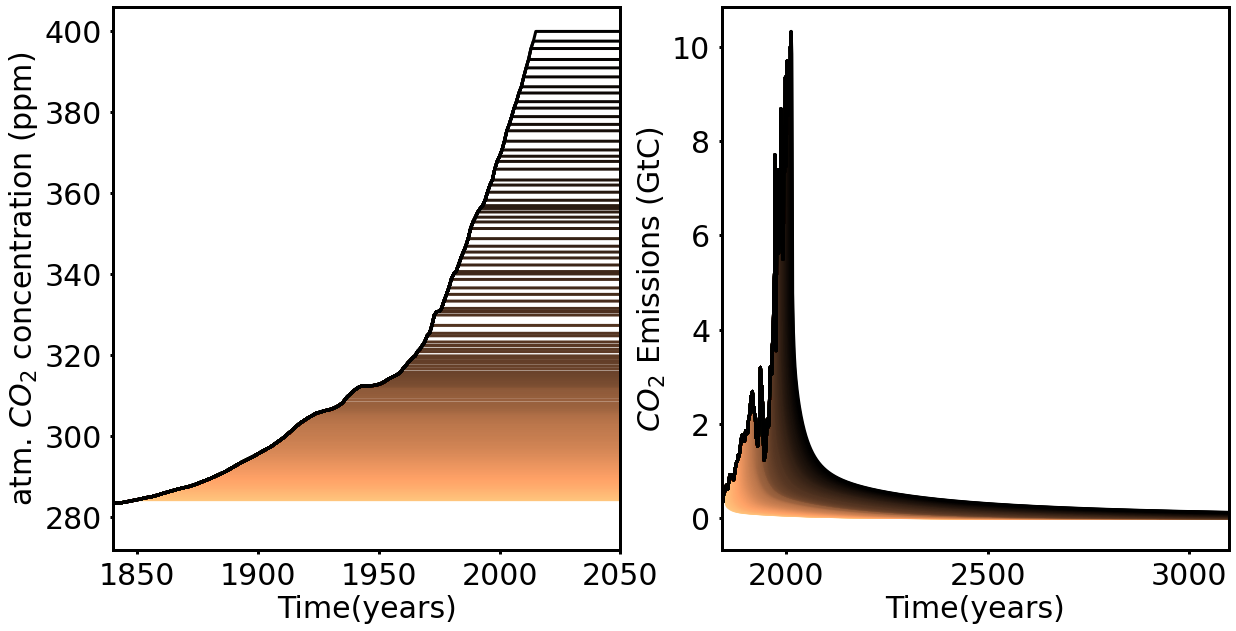

In [6]:
plt.figure(1,figsize=(20,10))
ax1=plt.subplot(121)
conc_out['C'].plot(legend=False,cmap='copper_r',ax=ax1)
ax1.set_ylabel(r'atm. $CO_2$ concentration (ppm)')
ax1.set_xlabel('Time(years)')
ax1.set_xlim(1840,2050)
ax2=plt.subplot(122)
ax2.set_xlim(1840,3100)
conc_out['Emissions'].plot(legend=False,cmap='copper_r',ax=ax2)
ax2.set_ylabel(r'$CO_2$ Emissions (GtC)')
ax2.set_xlabel('Time(years)');

Convert emission output from the concentration based run to an input DataFrame (delete the Gas cycle row and rename to Gas):

In [7]:
control_in = conc_out['Emissions'].droplevel(1,axis=1)
control_in.columns = control_in.columns.rename("Gas", level=1)

## 2. Control run

Run the simulation with the emissions above. (And makes sure that the atm. $CO_2$ concentration really is constant after the "pulse" year)

In [8]:
control_out = run_FaIR(emissions_in=control_in,forcing_in=return_empty_forcing(control_in),gas_parameters=test_gas,thermal_parameters=get_thermal_parameter_defaults())

Integrating 166 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1765 and 3100...


100%|██████████| 1335/1335 [00:00<00:00, 2733.89 timestep/s]


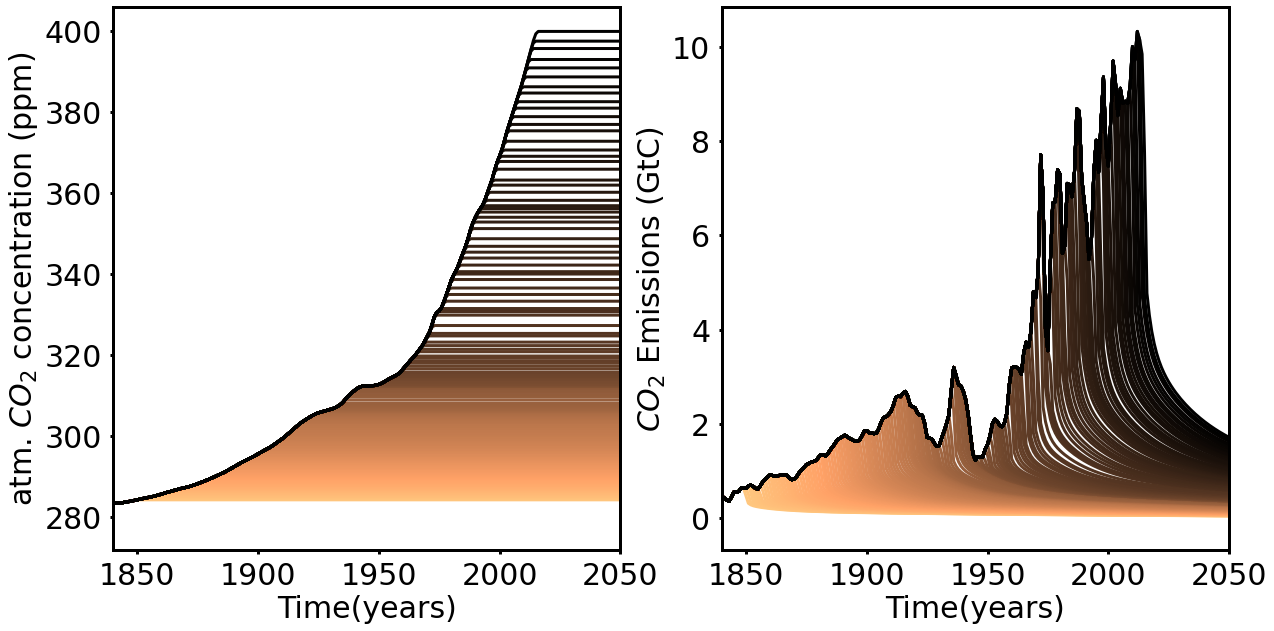

In [9]:
plt.figure(1,figsize=(20,10))
ax1=plt.subplot(121)
control_out['C'].plot(legend=False,cmap='copper_r',ax=ax1)
ax1.set_ylabel(r'atm. $CO_2$ concentration (ppm)')
ax1.set_xlabel('Time(years)')
ax1.set_xlim(1840,2050)
ax2=plt.subplot(122)
ax2.set_xlim(1840,2050)
control_out['Emissions'].plot(legend=False,cmap='copper_r',ax=ax2)
ax2.set_ylabel(r'$CO_2$ Emissions (GtC)')
ax2.set_xlabel('Time(years)');

Looks the same! Perfect! Almost done! 

### 3. Pulse run
Read the CO2 data first:

In [10]:
co2 = pd.read_csv('../../CO2_data/01_03_co2data_with_code.csv', parse_dates=True, sep=',', header=0).set_index('Code')
co2.columns = co2.columns.astype(int)

# sum over all countries
co2_per_yr = co2.sum()

# convert to Gt CO2
co2_per_yr = co2_per_yr/1e9

# convert to Gt C !!!!
co2_per_yr = co2_per_yr/3.67

# get CO2 data per country and year as proportion of total emission 
co2_perc = co2.apply(lambda x: x/x.sum(), axis=0)
co2_perc.columns = 'yr_' + co2_perc.columns.astype(str)

In [11]:
import copy
pulse_in = copy.deepcopy(control_in)
for t in range(1850,2016):
    pulse_in.loc[t,'yr_'+str(t)].carbon_dioxide = pulse_in.loc[t,'yr_'+str(t)].carbon_dioxide + co2_per_yr.loc[t]

In [12]:
pulse_out = run_FaIR(emissions_in=pulse_in,forcing_in=return_empty_forcing(pulse_in),gas_parameters=test_gas,thermal_parameters=get_thermal_parameter_defaults())

Integrating 166 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1765 and 3100...


100%|██████████| 1335/1335 [00:00<00:00, 2809.20 timestep/s]


In [19]:
# each century own color, shading for decadals
l = []
for c in [["546A7B",5],["62929E",10],["C6C5B9",2]]:
    l = l+ [(colors.to_rgba('#'+c[0],i)) for i in np.linspace(0.2,1,10)]*c[1]
# remove last 4 years
l = l[:-4]

co2_cmap=colors.ListedColormap(l)

# each century own color, shading for decadals
l = []
for c in [["9E2A2B",5],["BF6535",10],["E09F3E",2]]:
    l = l+ [(colors.to_rgba('#'+c[0],i)) for i in np.linspace(0.2,1,10)]*c[1]
# remove last 5 years
l = l[:-4]

T_cmap=colors.ListedColormap(l)

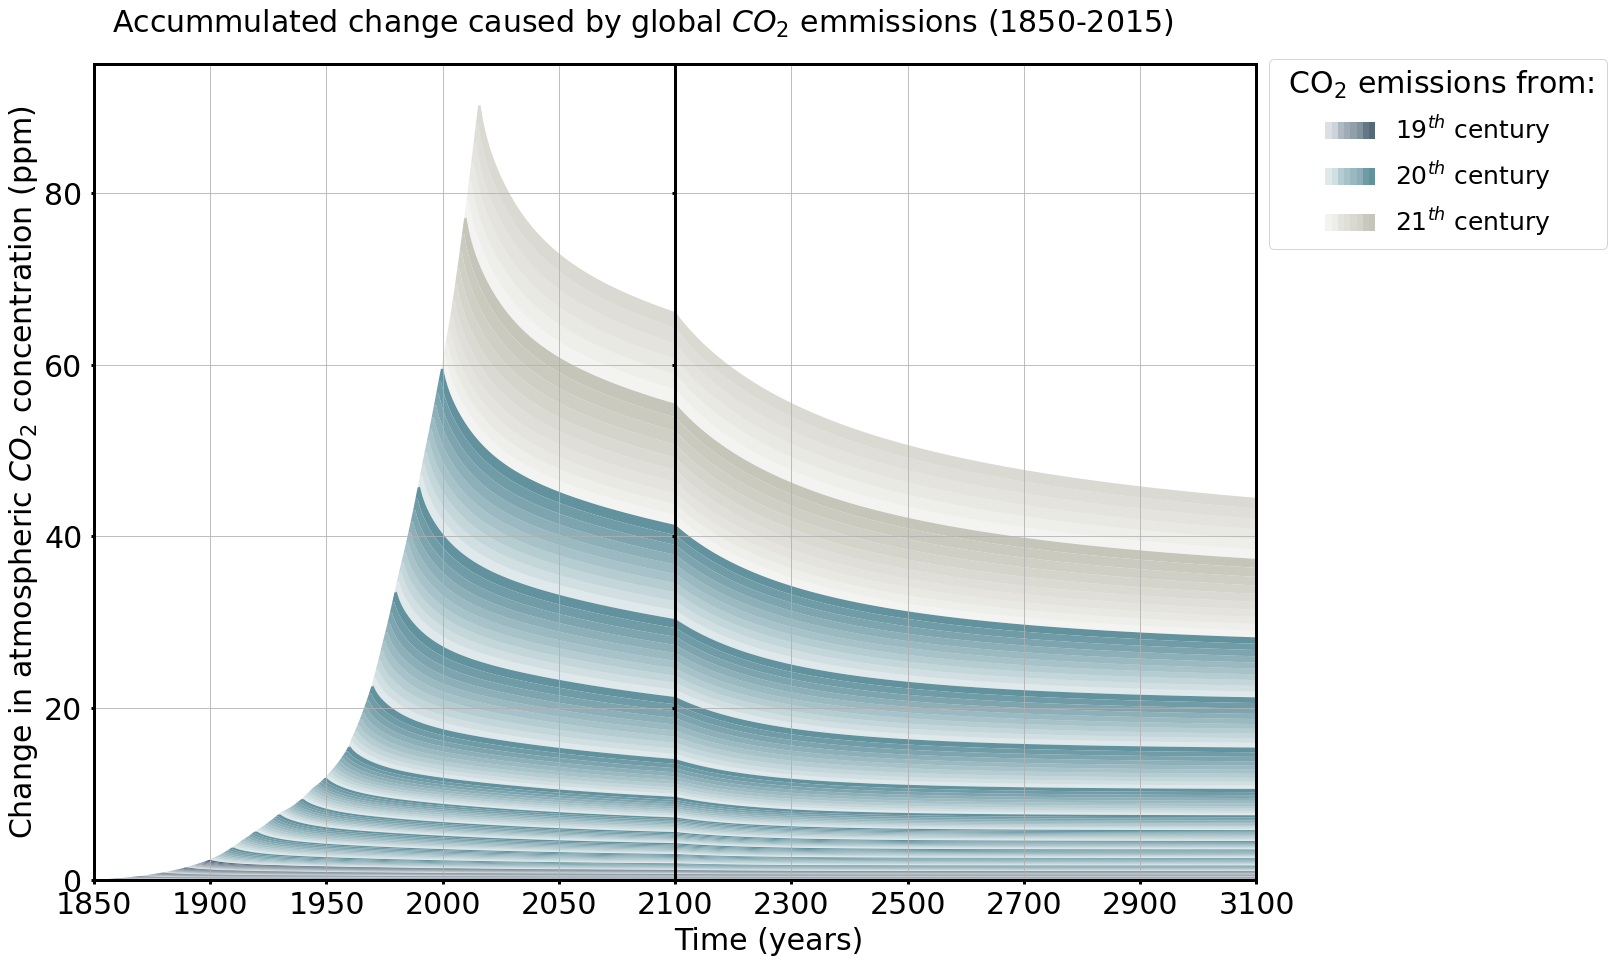

In [30]:
fig = plt.figure(figsize=(25, 15))
grid = plt.GridSpec(1, 12, hspace=0.2, wspace=0)
ax1 = plt.subplot(grid[0, :5])
ax2 = plt.subplot(grid[0, 5:10])
co2_diff = (pulse_out['C']-control_out['C']).droplevel(1,axis=1)
co2_diff.loc[:2100,:].plot.area(legend=False, linewidth=0,ax=ax1,cmap=co2_cmap)
co2_diff.loc[2100:,:].plot.area(legend=False, linewidth=0,ax=ax2,cmap=co2_cmap)

ax1.grid()
ax2.grid()

ax1.set_xlim(1850,2100)
ax2.set_xlim(2100,3000)
ax1.set_ylim(0,95)
ax2.set_ylim(0,95)

ax2.set_xticks(range(2300,3200,200))
ax2.set_yticklabels([])

ax1.set_xlabel(None)
ax2.set_xlabel(None)

ax1.set_ylabel(r'Change in atmospheric $CO_2$ concentration (ppm)')
fig.text(0.5, 0.06, 'Time (years)', ha='center')

fig.text(0.135,0.91, r'Accummulated change caused by global $CO_2$ emmissions (1850-2015)')

# legend
cmap_labels = [r'19$^{th}$ century', r'20$^{th}$ century', r'21$^{th}$ century']
cmaps=[color_to_cmap("546A7B"),color_to_cmap("62929E"),color_to_cmap("C6C5B9")]
# create proxy artists as handles:
cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,  loc='center left',bbox_to_anchor=(1, 0.89),
           fontsize=25, title= r' CO$_2$ emissions from: ')

#### Exkurs: Calculate Global mean temperature change based on CCR ~1.7 °C/TtC

In [17]:
ccr_mean = ((co2_per_yr.cumsum()/1000)*1.6).loc[:2015]
ccr_05p = ((co2_per_yr.cumsum()/1000)*1.0).loc[:2015]
ccr_95p = ((co2_per_yr.cumsum()/1000)*2.1).loc[:2015]

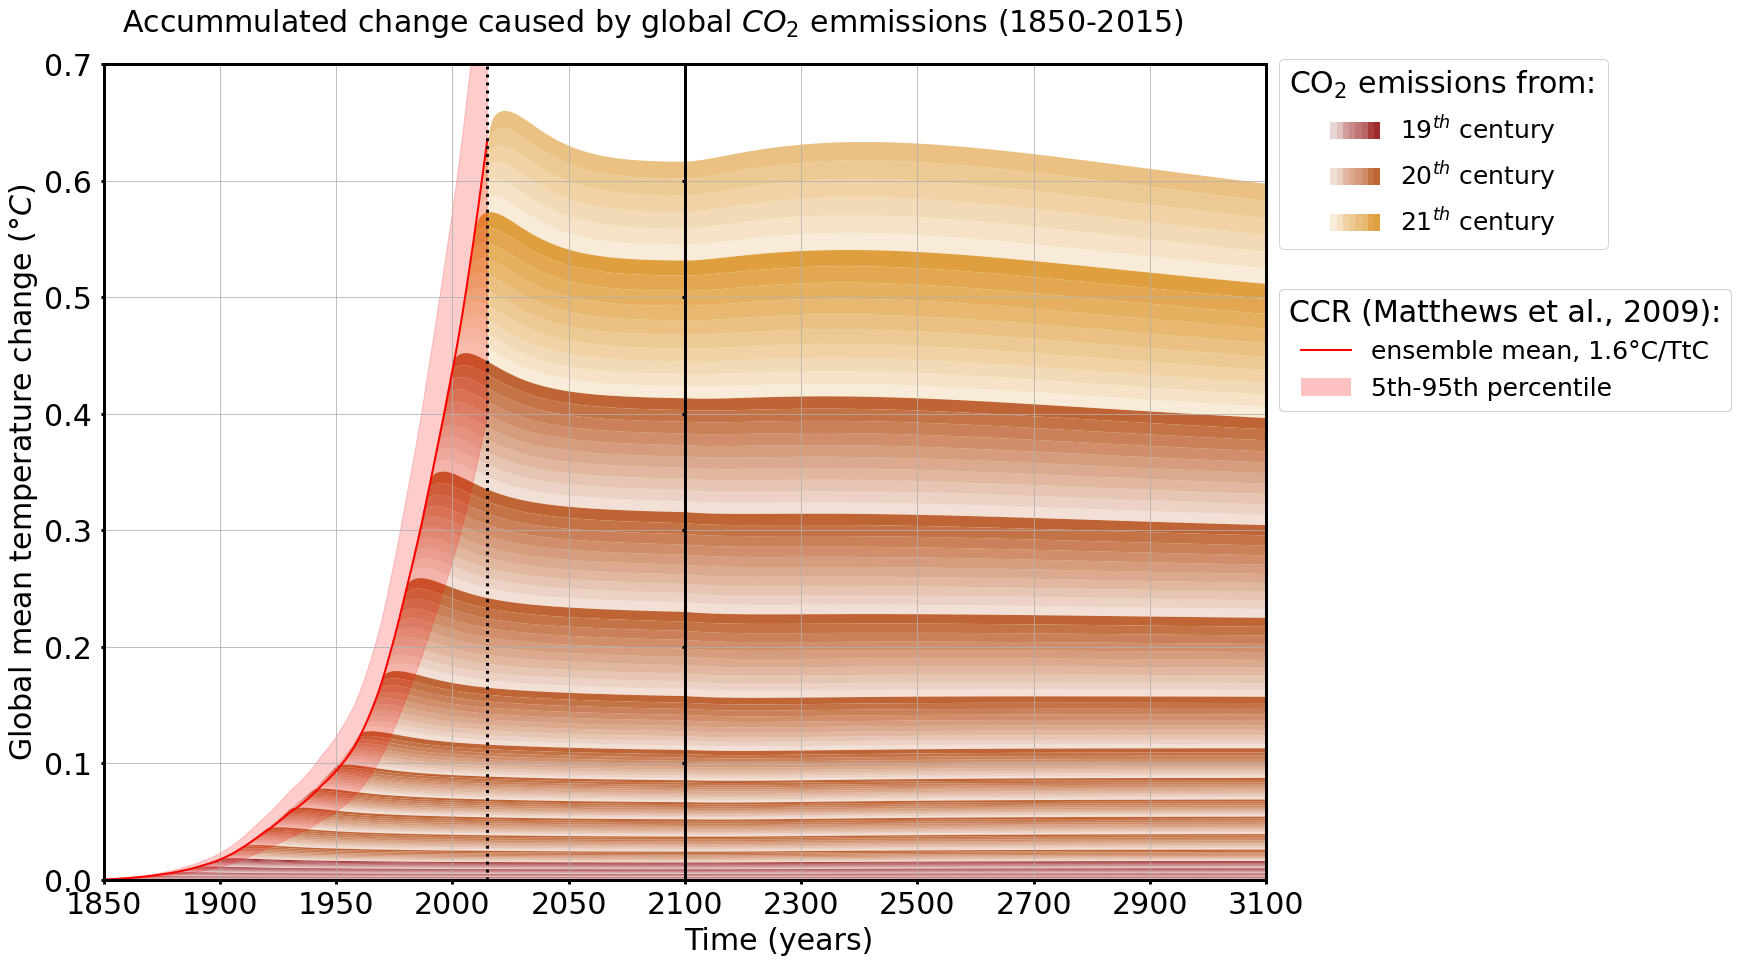

In [23]:
fig = plt.figure(figsize=(25, 15))
grid = plt.GridSpec(1, 12, hspace=0.2, wspace=0)
ax1 = plt.subplot(grid[0, :5])
ax2 = plt.subplot(grid[0, 5:10])
T_diff = (pulse_out['T']-control_out['T']).droplevel(1,axis=1)
T_diff.loc[:2100,:].plot.area(legend=False, linewidth=0,ax=ax1,cmap=T_cmap)
T_diff.loc[2100:,:].plot.area(legend=False, linewidth=0,ax=ax2,cmap=T_cmap)

ax1.plot(ccr_mean,lw=2,c='r')
ax1.fill_between(ccr_05p.index,ccr_05p.values,ccr_95p.values,color='r',alpha=0.2)

ax1.grid()
ax2.grid()

ax1.set_xlim(1850,2100)
ax2.set_xlim(2100,3000)
ax1.set_ylim(0,0.7)
ax2.set_ylim(0,0.7)

ax2.set_xticks(range(2300,3200,200))
ax2.set_yticklabels([])

ax1.set_xlabel(None)
ax2.set_xlabel(None)

ax1.axvline(2015,linestyle=':',c='k')

ax1.set_ylabel(r'Global mean temperature change ($\degree C$)')
fig.text(0.5, 0.06, 'Time (years)', ha='center')

fig.text(0.135,0.91, r'Accummulated change caused by global $CO_2$ emmissions (1850-2015)')

# legend
cmap_labels = [r'19$^{th}$ century', r'20$^{th}$ century', r'21$^{th}$ century']
cmaps=[color_to_cmap("9E2A2B"),color_to_cmap("BF6535"),color_to_cmap("E09F3E")]
# create proxy artists as handles:
cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
legend1 = ax2.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,  loc='center left',bbox_to_anchor=(1, 0.89),
           fontsize=25, title= r'CO$_2$ emissions from: ')
p1 = Line2D([0], [0], color='r', lw=2)
p2 = mpatches.Patch(color='r', alpha=0.2, linewidth=0)
legend2 = ax2.legend([p1,p2], ['ensemble mean, 1.6°C/TtC','5th-95th percentile'], title=r'CCR (Matthews et al., 2009):',fontsize=25,loc='center left',bbox_to_anchor=(1, 0.65))
ax2.add_artist(legend1)
ax2.add_artist(legend2)


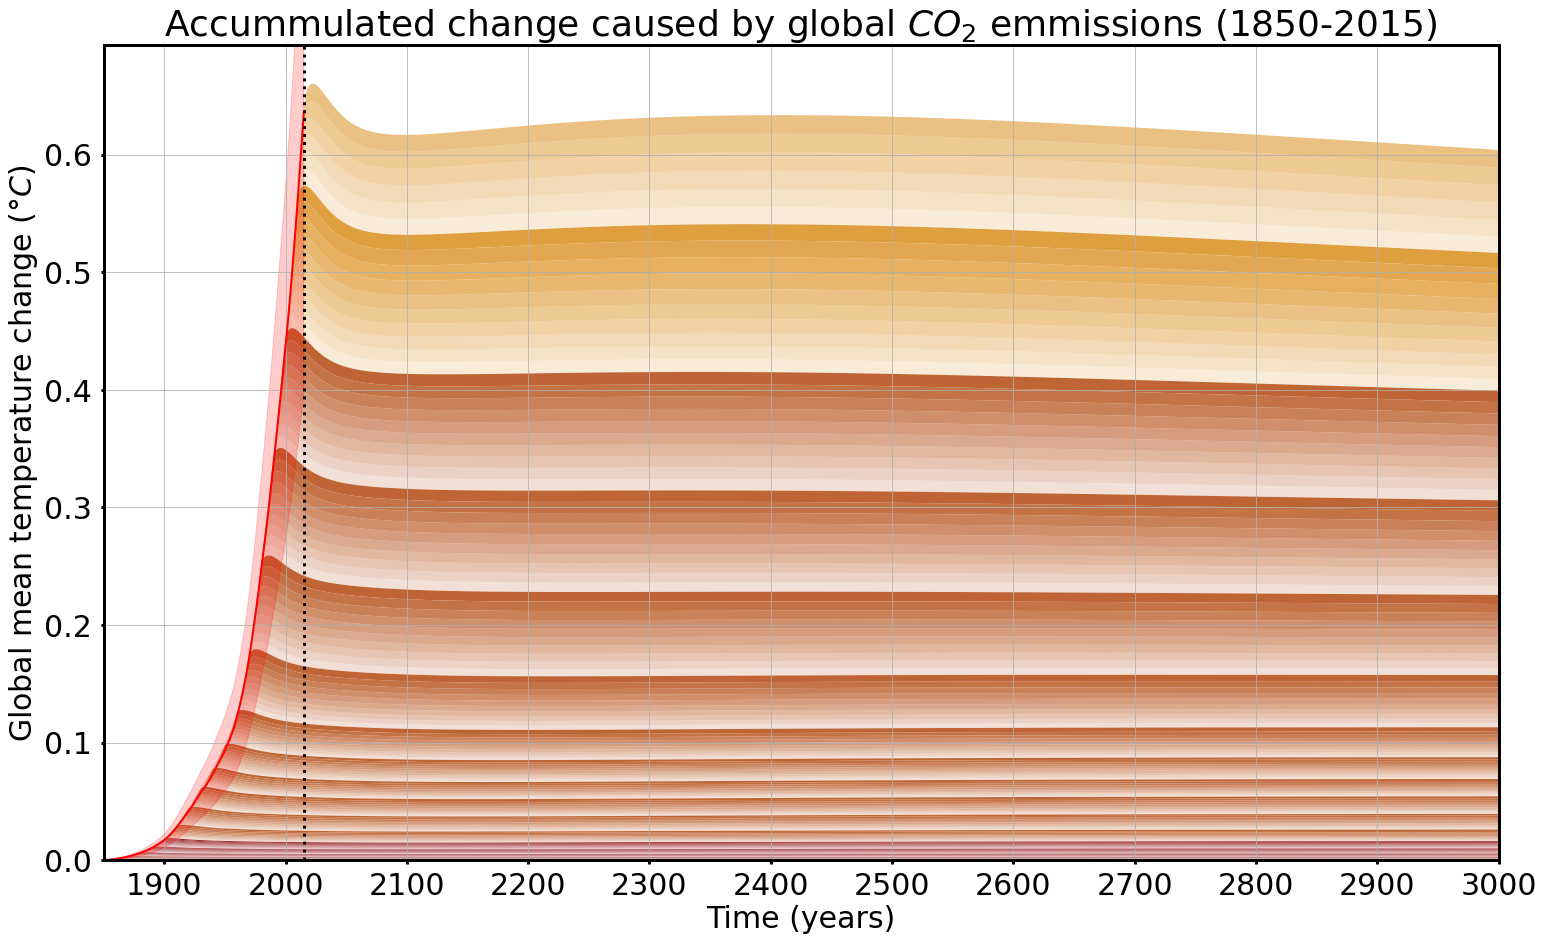

In [29]:
f, ax1 = plt.subplots(1,1,figsize=(25,15))
T_diff.plot.area(legend=False, linewidth=0,ax=ax1,cmap=T_cmap)

ax1.plot(ccr_mean,lw=2,c='r')
ax1.fill_between(ccr_05p.index,ccr_05p.values,ccr_95p.values,color='r',alpha=0.2)
ax1.axvline(2015,linestyle=':',c='k')
ax1.grid()
ax1.set_xlim(1850,3000)

plt.title(r'Accummulated change caused by global $CO_2$ emmissions (1850-2015)')
ax1.set_ylabel(r'Global mean temperature change ($\degree C$)')
ax1.set_xlabel('Time (years)')
ax1.set_xticks(range(1900,3100,100));

In [25]:
irf_df = pd.DataFrame(index=range(1000))
for t in co2_per_yr.loc[:2015].index:
    #print(t,co2_per_yr.loc[t])
    irf = co2_diff.loc[t:t+1000,'yr_'+str(t)]/(co2_per_yr.loc[t]/2.123)
    irf.index = irf.index-t
    irf.iloc[0]=1
    irf = irf.rename(columns={'carbon_dioxide':t})
    irf_df.loc[:,t] = irf

In [26]:
irf_df

,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.793770,0.793871,0.793976,0.794084,0.794192,0.794297,0.794401,0.794513,0.794631,0.794756,...,0.861369,0.862450,0.863554,0.864620,0.865740,0.866872,0.868006,0.869184,0.870329,0.871493
2,0.686855,0.686974,0.687099,0.687225,0.687347,0.687463,0.687582,0.687715,0.687857,0.688006,...,0.772234,0.773695,0.775244,0.776686,0.778299,0.779905,0.781494,0.783201,0.784782,0.786444
3,0.633494,0.633610,0.633733,0.633853,0.633968,0.634075,0.634187,0.634318,0.634457,0.634603,...,0.717092,0.718561,0.720181,0.721627,0.723352,0.725040,0.726692,0.728526,0.730142,0.731906
4,0.599731,0.599849,0.599976,0.600098,0.600213,0.600317,0.600427,0.600562,0.600703,0.600854,...,0.680694,0.682082,0.683659,0.685020,0.686726,0.688374,0.689972,0.691791,0.693331,0.695061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.216383,0.216385,0.216388,0.216390,0.216392,0.216394,0.216396,0.216399,0.216402,0.216405,...,0.264457,0.266306,0.268828,0.270641,0.273626,0.276386,0.278971,0.282395,0.284715,0.287806
996,0.216382,0.216385,0.216387,0.216390,0.216392,0.216393,0.216395,0.216398,0.216401,0.216405,...,0.264397,0.266244,0.268766,0.270578,0.273561,0.276321,0.278905,0.282329,0.284648,0.287738
997,0.216382,0.216384,0.216387,0.216389,0.216391,0.216393,0.216395,0.216398,0.216401,0.216404,...,0.264336,0.266183,0.268704,0.270515,0.273497,0.276256,0.278839,0.282262,0.284581,0.287670
998,0.216382,0.216384,0.216387,0.216389,0.216391,0.216392,0.216394,0.216397,0.216400,0.216404,...,0.264276,0.266122,0.268641,0.270453,0.273433,0.276191,0.278773,0.282195,0.284513,0.287602


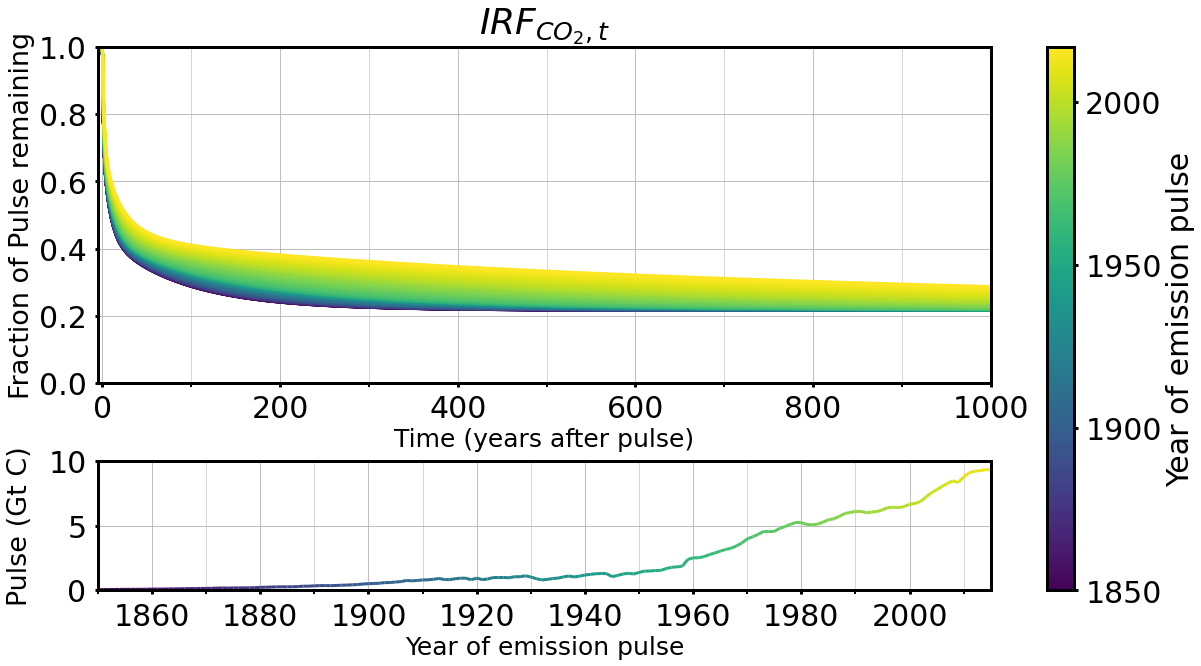

In [28]:

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig = plt.figure(figsize=(25, 15))
grid = plt.GridSpec(6, 10, hspace=3, wspace=0)
ax2 = plt.subplot(grid[:4, :])
ax1 = plt.subplot(grid[4:, :])

x = co2_per_yr.index
y = co2_per_yr.values
dydx = x  # first derivative
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
line = ax1.add_collection(lc,'o')
ax1.set_xlim(1850,2015)
ax1.set_ylim(0,10)
ax1.set_xlabel('Year of emission pulse',size=25)
ax1.set_ylabel('Pulse (Gt C)',size=27,labelpad=15)
ax1.grid()

cbar = fig.colorbar(line, ax=[ax1,ax2])
cbar.set_ticks([1850,1900,1950,2000])
cbar.set_label(r'Year of emission pulse')

irf_df.plot.line(cmap=plt.cm.viridis, figsize=(20,10), legend=False,grid=True,ax=ax2)
ax2.set_xlabel('Time (years after pulse)',size=25)
ax2.set_ylabel(r'Fraction of Pulse remaining',size=27)
ax2.set_title(r'$IRF_{CO_2,t}$')
ax2.set_xlim(-5,1000)
ax2.set_ylim(0,1)

ax2.tick_params(which='minor', length=4,width=2)
ax2.xaxis.set_minor_locator(MultipleLocator(100))
ax2.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.5)

ax1.tick_params(which='minor', length=4,width=2)
ax1.xaxis.set_minor_locator(MultipleLocator(10))
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.5)

#plt.savefig(os.path.join('plots','irf_t.png'),dpi=300);